# An Introduction to PCA with MNIST
_**Investigating Eigendigits from Principal Components Analysis on Handwritten Digits**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the PCA model](#Training-the-PCA-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)


## Introduction

Welcome to our example introducing Amazon SageMaker's PCA Algorithm! Today, we're analyzing the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which consists of images of handwritten digits, from zero to nine.  We'll ignore the true labels for the time being and instead focus on what information we can obtain from the image pixels alone.

The method that we'll look at today is called Principal Components Analysis (PCA).  PCA is an unsupervised learning algorithm that attempts to reduce the dimensionality (number of features) within a dataset while still retaining as much information as possible. This is done by finding a new set of feature dimensions called principal components, which are composites of the original features that are uncorrelated with one another. They are also constrained so that the first component accounts for the largest possible variability in the data, the second component the second most variability, and so on.

PCA is most commonly used as a pre-processing step.  Statistically, many models assume data to be low-dimensional.  In those cases, the output of PCA will actually include much less of the noise and subsequent models can be more accurate.  Taking datasets with a huge number of features and reducing them down can be shown to not hurt the accuracy of the clustering while enjoying significantly improved performance.  In addition, using PCA in advance of a linear model can make overfitting due to multi-collinearity less likely.

For our current use case though, we focus purely on the output of PCA.  [Eigenfaces](https://en.wikipedia.org/wiki/Eigenface) have been used for years in facial recognition and computer vision.  The eerie images represent a large library of photos as a smaller subset.  These eigenfaces are not necessarily clusters, but instead highlight key features, that when combined, can represent most of the variation in faces throughout the entire library.  We'll follow an analagous path and develop eigendigits from our handwritten digit dataset.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

_This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
import sagemaker
import boto3

sess = sagemaker.Session()

region = boto3.Session().region_name

# S3 bucket where the original mnist data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-sample-files"
downloaded_data_prefix = "datasets/image/MNIST"

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-pca-mnist"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

### Data ingestion

Next, we read the MNIST dataset [1] from an existing repository into memory, for preprocessing prior to training. It was downloaded from [here](http://deeplearning.net/data/mnist/mnist.pkl.gz). Processing could be done *in-situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present at the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets such as this one, reading into memory isn't onerous, though it would be for larger datasets.

> [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278-2324, November 1998.

In [2]:
%%time
import pickle, gzip, numpy, json

s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

CPU times: user 983 ms, sys: 356 ms, total: 1.34 s
Wall time: 1.63 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

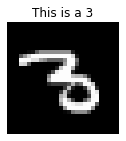

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2, 10)


def show_digit(img, caption="", subplot=None):
    if subplot is None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)


show_digit(train_set[0][30], "This is a {}".format(train_set[1][30]))

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of PCA takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as `sagemaker` below.

In [4]:
import io
import numpy as np
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]]).T

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors)
buf.seek(0)

0

## Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [5]:
%%time
import boto3
import os

key = "recordio-pb-data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://sagemaker-us-east-1-804604702169/sagemaker/DEMO-pca-mnist/train/recordio-pb-data
CPU times: user 2.42 s, sys: 555 ms, total: 2.97 s
Wall time: 3.29 s


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [6]:
output_location = f"s3://{bucket}/{prefix}/output"
print(f"training artifacts will be uploaded to: {output_location}")

training artifacts will be uploaded to: s3://sagemaker-us-east-1-804604702169/sagemaker/DEMO-pca-mnist/output


## Training the PCA model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the PCA training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed.  In this example that takes between 7 and 11 minutes.  Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our containers.  Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup.  More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [7]:
from sagemaker.image_uris import retrieve

container = retrieve(framework="pca", region=region)

Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters.  Notice:
- `feature_dim` is set to 50000.  We've transposed our datasets relative to most of the other MNIST examples because for eigendigits we're looking to understand pixel relationships, rather than make predictions about individual images.
- `num_components` has been set to 10.  This could easily be increased for future experimentation.  In practical settings, setting the number of components typically uses a mixture of objective and subjective criteria.  Data Scientists tend to look for the fewest principal components that eat up the most variation in the data.
- `subtract_mean` standardizes the pixel intensity across all images.  The MNIST data has already been extensively cleaned, but including this shouldn't hurt.
- `algorithm_mode` is set to 'randomized'.  Because we have a very large number of dimensions, this makes the most sense.  The alternative 'stable' should be used in cases with a lower value for `feature_dim`.
- `mini_batch_size` has been set to 200.  For PCA, this parameter should not affect fit, but may have slight implications on timing.  Other algorithms may require tuning of this parameter in order to achieve the best results.

In [8]:
import boto3
import sagemaker

sess = sagemaker.Session()

pca = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
pca.set_hyperparameters(
    feature_dim=50000,
    num_components=10,
    subtract_mean=True,
    algorithm_mode="randomized",
    mini_batch_size=200,
)

pca.fit({"train": s3_train_data})

2021-08-05 23:58:59 Starting - Starting the training job...
2021-08-05 23:59:23 Starting - Launching requested ML instancesProfilerReport-1628207939: InProgress
......
2021-08-06 00:00:23 Starting - Preparing the instances for training.........
2021-08-06 00:01:54 Downloading - Downloading input data...
2021-08-06 00:02:24 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/06/2021 00:02:44 INFO 139821325174592] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[08/06/2021 00:02:44 INFO 139821325174592] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '50000', 'algorithm_mo


2021-08-06 00:02:57 Uploading - Uploading generated training model
2021-08-06 00:02:57 Completed - Training job completed
Training seconds: 63
Billable seconds: 63


## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [9]:
pca_predictor = pca.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-----------------!

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [10]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

pca_predictor.ContentType = "text/csv"
pca_predictor.serializer = CSVSerializer()
pca_predictor.deserializer = JSONDeserializer()

Now let's try getting a prediction for a single record.

In [11]:
result = pca_predictor.predict(train_set[0][:, 0])
print(result)

{'projections': [{'projection': [-28.305532455444336, 2.799952507019043, 6.037816524505615, 0.908909797668457, -0.03693847358226776, -0.43731558322906494, -2.042056083679199, 1.9561119079589844, -0.4224138855934143, 3.8184704780578613]}]}


OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains a value for each of the 10 principal components we created when training the model.

Let's do a whole batch and see what comes out.

In [12]:
import numpy as np

eigendigits = []
for array in np.array_split(train_set[0].T, 100):
    result = pca_predictor.predict(array)
    eigendigits += [r["projection"] for r in result["projections"]]

eigendigits = np.array(eigendigits).T

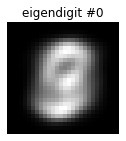

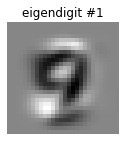

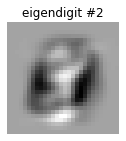

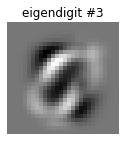

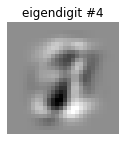

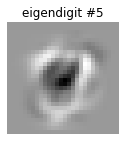

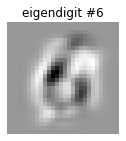

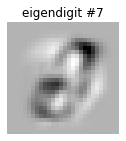

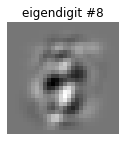

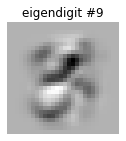

In [13]:
for e in enumerate(eigendigits):
    show_digit(e[1], f"eigendigit #{e[0]}")

Not surprisingly, the eigendigits aren't extremely interpretable.  They do show interesting elements of the data, with eigendigit #0 being the "anti-number", eigendigit #1 looking a bit like a `0` combined with the inverse of a `3`, eigendigit #2 showing some shapes resembling a `9`, and so on.

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [14]:
import sagemaker

sagemaker.Session().delete_endpoint(pca_predictor.endpoint_name)